In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib
# import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import sys
sys.path.append('../')

#import pretrainedmodels
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from gated import *
from resnet import *

In [2]:
# !pip install pretrainedmodels

In [3]:
# device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float

epochs = 20
BATCH_SIZE = 64

In [4]:
image_paths = list(paths.list_images('../data/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [5]:
len(set(labels))

101

In [6]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")


Total number of classes: 101


In [7]:
# define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [8]:
# divide the data into train, validation, and test set
(x_train, x_val , y_train, y_val) = train_test_split(data, labels, 
                                                    test_size=0.3,  
                                                    stratify=labels,
                                                    random_state=42)

(x_val, x_test, y_val, y_test) = train_test_split(x_val, y_val, 
                                                    test_size=0.65, 
                                                    random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (6073,)
x_test examples: (1693,)
x_val examples: (911,)


In [9]:
np.argmax(y_val[:20], axis=-1)

array([98,  3, 65, 52,  0,  1, 71, 72,  3,  3, 23,  3,  1, 55,  1, 11, 17,
       40, 90, 53])

In [10]:
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

In [11]:
# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
model = resnet18(pretrained=False).to(device)

dilation [False, False, False]
stride 1
downsample
stride 2
downsample
stride 2
downsample
stride 2


In [13]:
# model.eval()
for i in model.parameters():
    pass
#     print(i.shape)
#     print((i[0].type()))
state_dict = model.state_dict()
for i in state_dict :
    print(i)
#     if 'conv1.weight' in i :
#         print(state_dict[i][0,0])

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn1.running_mean
layer2.0.bn1.running_var
layer2.0.bn1.num_batches_tracked
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.bn2.running_mean
layer2.0.bn2.running_var
layer2.0.bn2.num_batches_tracked
layer2.0.downsample.0.weight
layer2.0.downsamp

In [14]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [15]:
# training function
def fit(model, dataloader):
#     print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [16]:
#validation function
def validate(model, dataloader):
#     print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy

In [17]:
def test(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, target = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == torch.max(target, 1)[1]).sum().item()
    return correct, total

  0%|          | 0/94 [00:00<?, ?it/s]

Training on 6073 examples, validating on 911 examples...


95it [00:09, 10.29it/s]                        
  7%|▋         | 1/14 [00:00<00:01,  8.78it/s]

Train Loss: 0.0515, Train Acc: 30.18


15it [00:01, 11.64it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.81it/s]

Val Loss: 0.0547, Val Acc: 33.04


95it [00:08, 10.77it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.93it/s]

Train Loss: 0.0405, Train Acc: 40.57


15it [00:01, 12.30it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 11.18it/s]

Val Loss: 0.0405, Val Acc: 43.03


95it [00:08, 10.75it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.56it/s]

Train Loss: 0.0355, Train Acc: 47.16


15it [00:01, 12.26it/s]                        
  1%|          | 1/94 [00:00<00:09,  9.38it/s]

Val Loss: 0.0392, Val Acc: 47.09


95it [00:08, 10.71it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.72it/s]

Train Loss: 0.0315, Train Acc: 51.34


15it [00:01, 11.97it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.59it/s]

Val Loss: 0.0337, Val Acc: 52.47


95it [00:08, 10.60it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.58it/s]

Train Loss: 0.0276, Train Acc: 56.69


15it [00:01, 12.02it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.86it/s]

Val Loss: 0.0323, Val Acc: 51.26


95it [00:08, 10.61it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.71it/s]

Train Loss: 0.0246, Train Acc: 60.86


15it [00:01, 12.03it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.89it/s]

Val Loss: 0.0322, Val Acc: 55.54


95it [00:08, 10.65it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.86it/s]

Train Loss: 0.0219, Train Acc: 65.07


15it [00:01, 12.31it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 11.02it/s]

Val Loss: 0.0280, Val Acc: 59.06


95it [00:08, 10.68it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.68it/s]

Train Loss: 0.0194, Train Acc: 68.30


15it [00:01, 12.24it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.56it/s]

Val Loss: 0.0272, Val Acc: 61.14


95it [00:08, 10.69it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.96it/s]

Train Loss: 0.0169, Train Acc: 72.11


15it [00:01, 11.97it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.60it/s]

Val Loss: 0.0258, Val Acc: 62.35


95it [00:08, 10.68it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.92it/s]

Train Loss: 0.0146, Train Acc: 76.27


15it [00:01, 12.25it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.66it/s]

Val Loss: 0.0238, Val Acc: 62.35


95it [00:08, 10.67it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.00it/s]

Train Loss: 0.0119, Train Acc: 79.85


15it [00:01, 11.82it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.74it/s]

Val Loss: 0.0219, Val Acc: 66.85


95it [00:08, 10.68it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.95it/s]

Train Loss: 0.0101, Train Acc: 82.99


15it [00:01, 12.34it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.87it/s]

Val Loss: 0.0218, Val Acc: 67.07


95it [00:08, 10.69it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.80it/s]

Train Loss: 0.0087, Train Acc: 85.76


15it [00:01, 12.09it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.93it/s]

Val Loss: 0.0209, Val Acc: 68.28


95it [00:08, 10.65it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.82it/s]

Train Loss: 0.0072, Train Acc: 88.18


15it [00:01, 12.32it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.81it/s]

Val Loss: 0.0236, Val Acc: 66.30


95it [00:08, 10.70it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.58it/s]

Train Loss: 0.0055, Train Acc: 91.45


15it [00:01, 12.08it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.98it/s]

Val Loss: 0.0193, Val Acc: 69.48


95it [00:08, 10.63it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.79it/s]

Train Loss: 0.0041, Train Acc: 94.14


15it [00:01, 12.16it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.85it/s]

Val Loss: 0.0191, Val Acc: 71.13


95it [00:08, 10.68it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.91it/s]

Train Loss: 0.0028, Train Acc: 96.39


15it [00:01, 12.23it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.64it/s]

Val Loss: 0.0191, Val Acc: 71.79


95it [00:08, 10.61it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.53it/s]

Train Loss: 0.0018, Train Acc: 98.25


15it [00:01, 12.24it/s]                        
  2%|▏         | 2/94 [00:00<00:08, 10.66it/s]

Val Loss: 0.0185, Val Acc: 72.01


95it [00:08, 10.73it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.76it/s]

Train Loss: 0.0009, Train Acc: 99.64


15it [00:01, 12.28it/s]                        
  1%|          | 1/94 [00:00<00:09,  9.82it/s]

Val Loss: 0.0169, Val Acc: 73.66


95it [00:08, 10.67it/s]                        
 14%|█▍        | 2/14 [00:00<00:01, 11.54it/s]

Train Loss: 0.0004, Train Acc: 99.82


15it [00:01, 11.93it/s]                        


Val Loss: 0.0164, Val Acc: 75.85
3.3852421482404074 minutes


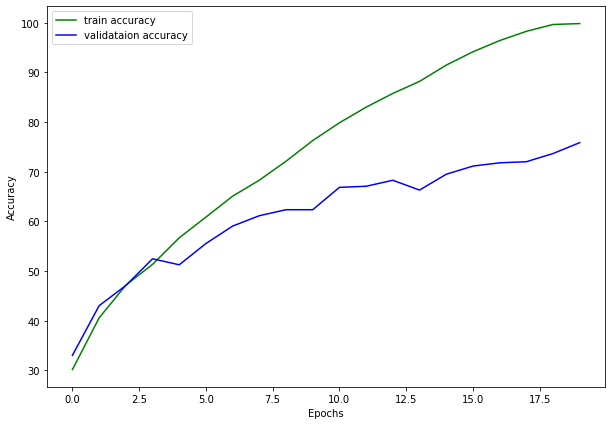

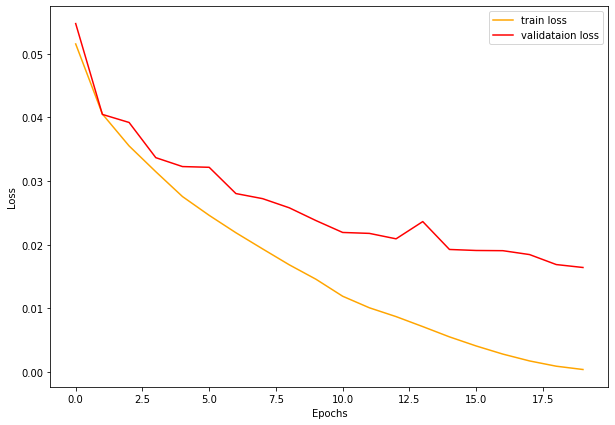

In [18]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
start = time.time()
for epoch in range(epochs):
#     print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')
torch.save(model.state_dict(), f"../trained_models/resnet18_epochs{epochs}.pth")
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../outputs/plots/accuracy.png')
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/plots/loss.png')

In [19]:
correct, total = test(model, testloader)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

Accuracy of the network on test images: 74.778 %
train.py finished running


In [20]:
state_dict = model.state_dict()
for i in state_dict :
#     print(i)
    if 'conv1.weight' in i :
        print(state_dict[i][0,0])

tensor([[ 0.0481,  0.0230, -0.0102,  0.0077,  0.0141,  0.0173, -0.0202],
        [ 0.0182,  0.0146,  0.0104,  0.0070, -0.0326,  0.0014, -0.0030],
        [ 0.0307, -0.0092,  0.0614,  0.0713, -0.0109,  0.0170, -0.0242],
        [ 0.0159, -0.0029,  0.0125, -0.0159, -0.0263, -0.0042, -0.0270],
        [-0.0424,  0.0305, -0.0060, -0.0194,  0.0064,  0.0202,  0.0397],
        [-0.0172, -0.0145, -0.0524,  0.0177,  0.0354,  0.0231,  0.0472],
        [-0.0255, -0.0217, -0.0476,  0.0089, -0.0131, -0.0176,  0.0033]],
       device='cuda:0')
tensor([[ 0.0381, -0.0401,  0.0025],
        [-0.0087, -0.0226, -0.0140],
        [-0.0816,  0.0100, -0.1186]], device='cuda:0')
tensor([[ 0.0883,  0.0006,  0.0360],
        [-0.0070,  0.0072, -0.0773],
        [ 0.0266, -0.0549, -0.0455]], device='cuda:0')
tensor([[-0.0083,  0.0245,  0.0888],
        [ 0.0189, -0.0305,  0.0644],
        [-0.0177,  0.0136, -0.1484]], device='cuda:0')
tensor([[-0.0453, -0.0591,  0.0312],
        [ 0.0138, -0.0245, -0.0981],
   